# Two Sigma Financial Modelling #

First glance at the problem description:

- The problem is consructed more like like reinforcement learning problem. When treating it as a supervised learning problem we are simply ignoring the rewards which is a big waste. However, reinforcement learning in a noisy non-controlled environment can be very difficult. One cannot tell the system is indeed improving or simply caused by noise.

- On top of the last, the meric R used by Kaggle is also not a good reward function for reinforcement learning or a good metric in general. These individual rewards are very hard to make sense since it is highly influenced by the mean target value of the given timestamp. Perhaps the cumulative R value till the given timestamp is better?

- Financial data can be too noisy for exotic algorithms. Most importantly, learning historical data might not be the most effective way for prediction. Looking for similarity to the oil prices and stock indeces might yield better results. However, we have no idea about the timeframe of this dataset. Therefore, use some simple Linear Regression algorithm like Ridge, Lasso or Elastic Net instead. Perhaps stack or blend something else later on based on the results. **In fact I did see other participants using stacking xtree*0.65 + linear*0.35 with gaining better results**

- Read upon some research shows that for financial data, transformation such as X' = 1 / (1 + exp(-X)) helps. Fundamental factor model (two cross linear regression) might also show some improvement.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
%matplotlib inline
#import kagglegym
from plot_learning_curve import plot_learning_curve
import seaborn as sns
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

#from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

In [2]:
df_train = pd.read_hdf("../input/train.h5")
df_train.head()

,id,timestamp,derived_0,derived_1,derived_2,derived_3,derived_4,fundamental_0,fundamental_1,fundamental_2,...,technical_36,technical_37,technical_38,technical_39,technical_40,technical_41,technical_42,technical_43,technical_44,y
0,10,0,0.370326,-0.006316,0.222831,-0.213030,0.729277,-0.335633,0.113292,1.621238,...,0.775208,NaN,NaN,NaN,-0.414776,NaN,NaN,-2.0,NaN,-0.011753
1,11,0,0.014765,-0.038064,-0.017425,0.320652,-0.034134,0.004413,0.114285,-0.210185,...,0.025590,NaN,NaN,NaN,-0.273607,NaN,NaN,-2.0,NaN,-0.001240
2,12,0,-0.010622,-0.050577,3.379575,-0.157525,-0.068550,-0.155937,1.219439,-0.764516,...,0.151881,NaN,NaN,NaN,-0.175710,NaN,NaN,-2.0,NaN,-0.020940
3,25,0,NaN,NaN,NaN,NaN,NaN,0.178495,NaN,-0.007262,...,1.035936,NaN,NaN,NaN,-0.211506,NaN,NaN,-2.0,NaN,-0.015959
4,26,0,0.176693,-0.025284,-0.057680,0.015100,0.180894,0.139445,-0.125687,-0.018707,...,0.630232,NaN,NaN,NaN,-0.001957,NaN,NaN,0.0,NaN,-0.007338


A lot of features (or factors, in the financial industry) in this datasets.

In [3]:
df_train.describe()

,id,timestamp,derived_0,derived_1,derived_2,derived_3,derived_4,fundamental_0,fundamental_1,fundamental_2,...,technical_36,technical_37,technical_38,technical_39,technical_40,technical_41,technical_42,technical_43,technical_44,y
count,1.710756e+06,1.710756e+06,1.637797e+06,1.629727e+06,1.312105e+06,1.561285e+06,1.304298e+06,1.686809e+06,1.031686e+06,1.341916e+06,...,1.708204e+06,1.691591e+06,1.691591e+06,1.690740e+06,1.708520e+06,1.666567e+06,1.690755e+06,1.706070e+06,1.473977e+06,1.710756e+06
mean,1.093858e+03,9.456257e+02,-4.537569e+00,7.729437e+11,-3.321289e-01,-5.047151e-01,1.803233e+01,-2.041142e-02,-5.703752e+08,-1.623607e-01,...,-8.584284e-02,-9.108464e-02,-8.161018e-02,-7.290059e-02,4.907529e-02,5.236320e-03,-1.700147e-02,-9.735643e-01,3.881556e-04,2.217474e-04
std,6.308563e+02,5.195685e+02,2.497790e+02,7.620848e+13,6.521051e+01,1.020845e+02,9.260062e+02,2.496619e-01,7.502489e+10,3.675968e+00,...,6.129349e-01,2.476959e-01,2.333819e-01,2.230485e-01,3.105295e-01,1.134394e-01,2.121332e-01,9.626583e-01,3.013458e-02,2.242171e-02
min,0.000000e+00,0.000000e+00,-2.017497e+04,-7.375435e-02,-9.848880e+03,-3.434176e+04,-8.551914e+03,-2.344957e+00,-1.043737e+13,-1.077101e+03,...,-1.687572e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-5.250904e-01,-4.449529e-01,-1.000000e+00,-2.000000e+00,-1.265686e-01,-8.609413e-02
25%,5.500000e+02,5.040000e+02,-1.449710e-01,-2.956479e-02,-5.967524e-02,-1.655826e-01,-1.057050e-01,-1.996543e-01,-1.960470e-01,-2.280967e-01,...,-4.050297e-01,-4.651562e-04,-1.992532e-04,-2.203252e-05,-1.521701e-01,-7.377038e-02,-3.887695e-15,-2.000000e+00,-1.998819e-02,-9.561389e-03
50%,1.098000e+03,9.560000e+02,-8.368272e-04,5.523058e-03,2.109505e-02,2.475614e-03,1.175234e-02,-4.064488e-02,-7.395084e-03,-3.029069e-02,...,-8.502064e-02,-3.951567e-12,-1.418487e-13,-1.591224e-16,-1.476793e-02,9.782702e-05,0.000000e+00,-6.597540e-01,1.117279e-05,-1.570681e-04
75%,1.657000e+03,1.401000e+03,1.199108e-01,1.078554e-01,1.952209e-01,3.037236e-01,1.556464e-01,1.303819e-01,1.832071e-01,1.764751e-01,...,1.909600e-01,-5.219879e-40,0.000000e+00,0.000000e+00,1.772415e-01,7.855728e-02,0.000000e+00,-5.188884e-08,2.047074e-02,9.520990e-03
max,2.158000e+03,1.812000e+03,3.252527e+03,1.068448e+16,3.823001e+03,1.239737e+03,6.785965e+04,1.378195e+00,5.203165e+02,7.677125e+01,...,4.957758e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.569265e+00,6.844833e-01,1.000000e+00,0.000000e+00,1.435858e-01,9.349781e-02


In [50]:
df_train.shape

(1710756, 217)

## Exploaratory Data Analysis ##

Each id is a financial assect. Let's see what y looks like.

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


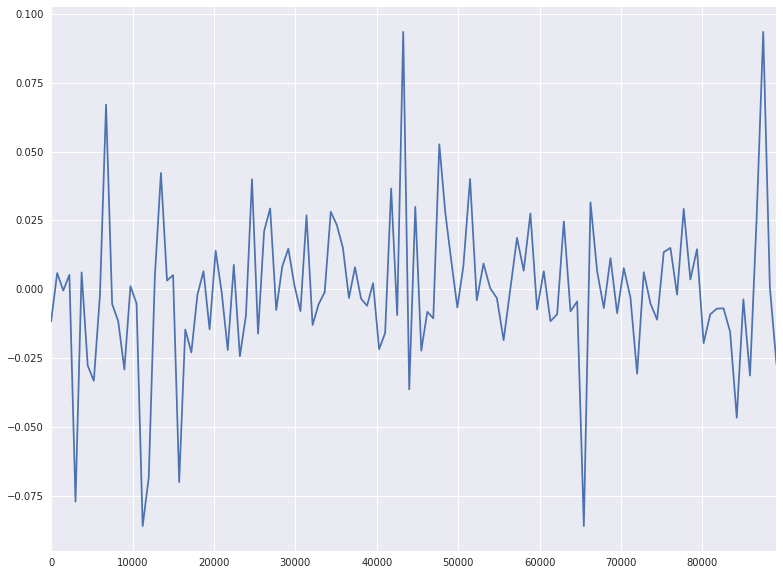

In [5]:
df_train[df_train.id==10].y.plot(figsize=(13,10))

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


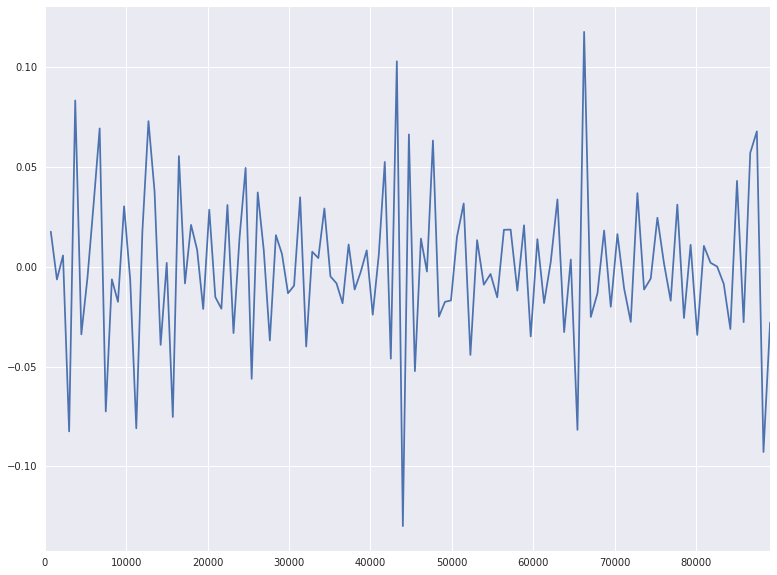

In [7]:
df_train[df_train.id==10].y.diff().plot(figsize=(13,10))

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


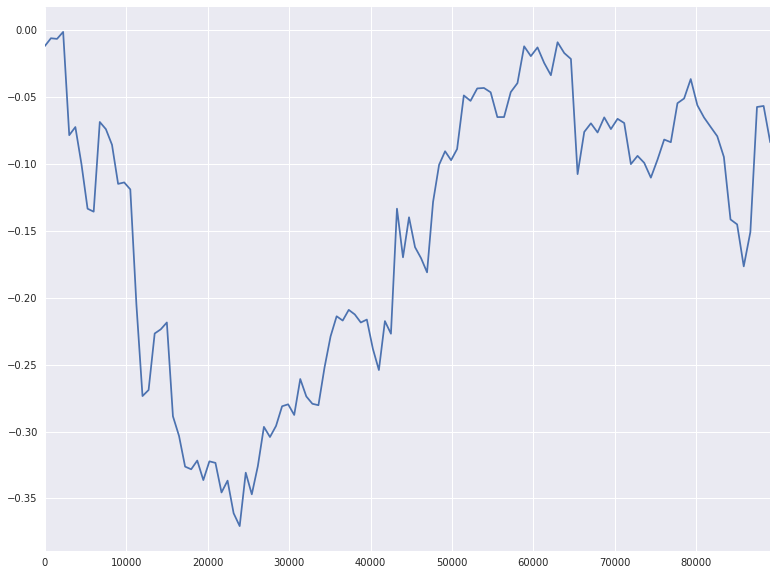

In [6]:
# Still way too unstable, look at cumsum now
df_train[df_train.id==10].y.cumsum().plot(figsize=(13,10))

Looking like moving average.

Since I am going to use linear regression for this problem. Outliers need to be removed first. Check to see if there is any.

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


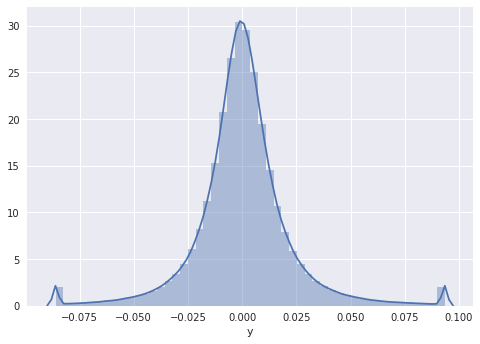

In [22]:
sns.distplot(df_train.y)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


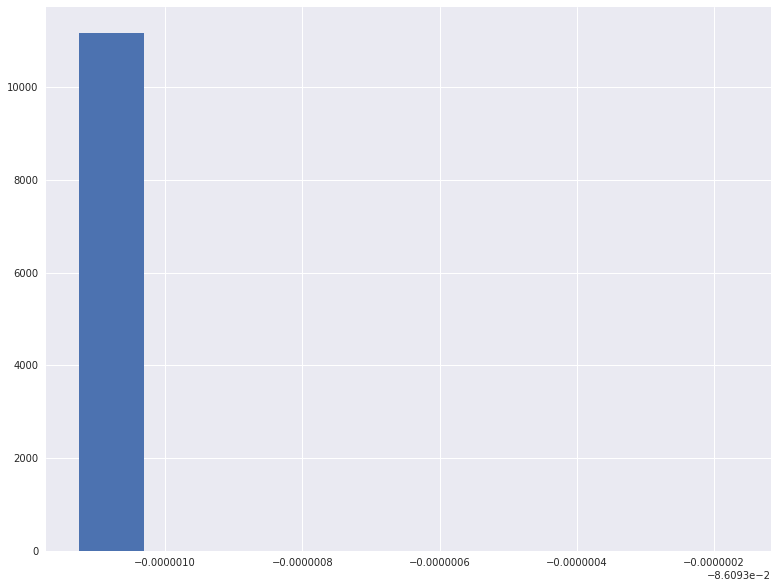

In [21]:
# Zooming in
df_train[df_train.y<-0.086092].y.hist(figsize=(13,10))

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


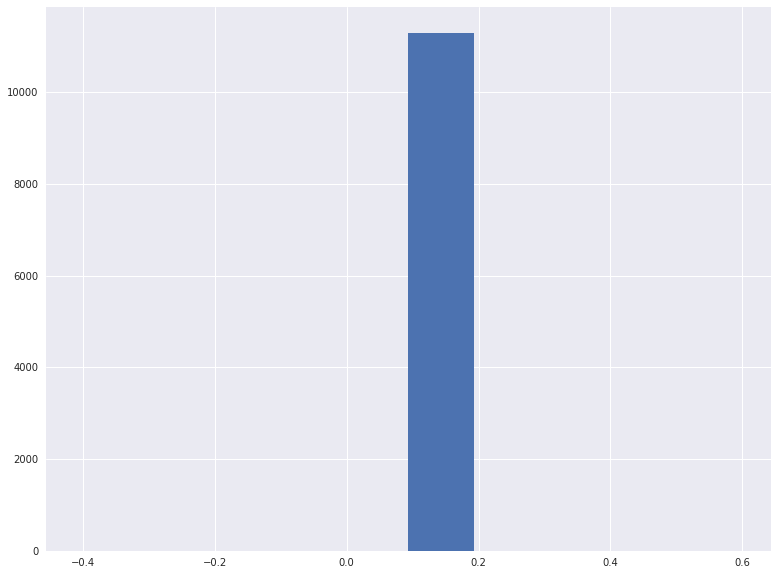

In [27]:
# Zooming in
df_train[df_train.y>0.093496].y.hist(figsize=(13,10))

In [3]:
#clipping
low_y_cut = -0.086093
high_y_cut = 0.093497

y_within_the_cut = (df_train.y > low_y_cut) & (df_train.y < high_y_cut)
new_df_train = df_train[y_within_the_cut].copy()

Next, how many missing values are there?

In [14]:
df_train.isnull().sum()

id                     0
timestamp              0
derived_0          72959
derived_1          81029
derived_2         398651
derived_3         149471
derived_4         406458
fundamental_0      23947
fundamental_1     679070
fundamental_2     368840
fundamental_3     454380
fundamental_5     962020
fundamental_6     701625
fundamental_7      26340
fundamental_8     373166
fundamental_9     565567
fundamental_10    112977
fundamental_11    368840
fundamental_12    110871
fundamental_13    355138
fundamental_14    356084
fundamental_15    354897
fundamental_16    355138
fundamental_17     97222
fundamental_18     15833
fundamental_19     54588
fundamental_20    110871
fundamental_21     54333
fundamental_22    558488
fundamental_23    356723
                   ...  
technical_13        4764
technical_14       14184
technical_16       19981
technical_17        4279
technical_18       20016
technical_19        2320
technical_20        4764
technical_21        2236
technical_22           0


That is a lot of missing values. We could fillna with median for a quick and ditry try but it is best to use clustering for later experiment.

However, before we do, it is best to keep these nan vales because they might follow a certain pattern. Why are they missing in the first place? Are they missing because some assets are being sold so no long available or perhaps they do not have much information in the first place?

In [4]:
# Keeping the original columns that contain nan values

cols = [column for column in new_df_train.columns if column not in ['id', 'timestamp', 'y']]

for col in cols:
    temp = new_df_train[col].isnull()
    if np.sum(temp) > 0:
        new_df_train[col + '_nan'] = temp * 1
        
new_df_train

,id,timestamp,derived_0,derived_1,derived_2,derived_3,derived_4,fundamental_0,fundamental_1,fundamental_2,...,technical_35_nan,technical_36_nan,technical_37_nan,technical_38_nan,technical_39_nan,technical_40_nan,technical_41_nan,technical_42_nan,technical_43_nan,technical_44_nan
0,10,0,0.370326,-0.006316,0.222831,-0.213030,0.729277,-0.335633,0.113292,1.621238,...,0,0,1,1,1,0,1,1,0,1
1,11,0,0.014765,-0.038064,-0.017425,0.320652,-0.034134,0.004413,0.114285,-0.210185,...,0,0,1,1,1,0,1,1,0,1
2,12,0,-0.010622,-0.050577,3.379575,-0.157525,-0.068550,-0.155937,1.219439,-0.764516,...,0,0,1,1,1,0,1,1,0,1
3,25,0,NaN,NaN,NaN,NaN,NaN,0.178495,NaN,-0.007262,...,0,0,1,1,1,0,1,1,0,1
4,26,0,0.176693,-0.025284,-0.057680,0.015100,0.180894,0.139445,-0.125687,-0.018707,...,0,0,1,1,1,0,1,1,0,1
5,27,0,0.346856,0.166239,-6.080701,-0.992249,-0.125916,0.345812,NaN,-0.584239,...,0,0,1,1,1,0,1,1,0,1
6,31,0,0.072036,0.014931,NaN,0.014063,NaN,-0.193205,NaN,NaN,...,0,0,1,1,1,0,1,1,0,1
7,38,0,0.300062,0.071251,-0.074451,-0.065292,-0.011286,0.026365,0.210249,0.167494,...,0,0,1,1,1,0,1,1,0,1
8,39,0,-0.003511,-0.034270,0.082372,-0.023937,-0.025750,0.007815,0.263451,-0.241212,...,0,0,1,1,1,0,1,1,0,1
9,40,0,-0.083330,0.081935,-2.048438,-0.206856,-0.839563,-0.234100,-0.291853,-5.722336,...,0,0,1,1,1,0,1,1,0,1


In [5]:
#fill missing
#new_df_train = new_df_train.fillna(new_df_train.median())
new_df_train.fillna(new_df_train.median(), inplace=True)

,id,timestamp,derived_0,derived_1,derived_2,derived_3,derived_4,fundamental_0,fundamental_1,fundamental_2,...,technical_35_nan,technical_36_nan,technical_37_nan,technical_38_nan,technical_39_nan,technical_40_nan,technical_41_nan,technical_42_nan,technical_43_nan,technical_44_nan
0,10,0,0.370326,-0.006316,0.222831,-0.213030,0.729277,-0.335633,0.113292,1.621238,...,0,0,1,1,1,0,1,1,0,1
1,11,0,0.014765,-0.038064,-0.017425,0.320652,-0.034134,0.004413,0.114285,-0.210185,...,0,0,1,1,1,0,1,1,0,1
2,12,0,-0.010622,-0.050577,3.379575,-0.157525,-0.068550,-0.155937,1.219439,-0.764516,...,0,0,1,1,1,0,1,1,0,1
3,25,0,-0.000413,0.005194,0.020909,0.002887,0.011996,0.178495,-0.006489,-0.007262,...,0,0,1,1,1,0,1,1,0,1
4,26,0,0.176693,-0.025284,-0.057680,0.015100,0.180894,0.139445,-0.125687,-0.018707,...,0,0,1,1,1,0,1,1,0,1
5,27,0,0.346856,0.166239,-6.080701,-0.992249,-0.125916,0.345812,-0.006489,-0.584239,...,0,0,1,1,1,0,1,1,0,1
6,31,0,0.072036,0.014931,0.020909,0.014063,0.011996,-0.193205,-0.006489,-0.029062,...,0,0,1,1,1,0,1,1,0,1
7,38,0,0.300062,0.071251,-0.074451,-0.065292,-0.011286,0.026365,0.210249,0.167494,...,0,0,1,1,1,0,1,1,0,1
8,39,0,-0.003511,-0.034270,0.082372,-0.023937,-0.025750,0.007815,0.263451,-0.241212,...,0,0,1,1,1,0,1,1,0,1
9,40,0,-0.083330,0.081935,-2.048438,-0.206856,-0.839563,-0.234100,-0.291853,-5.722336,...,0,0,1,1,1,0,1,1,0,1


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


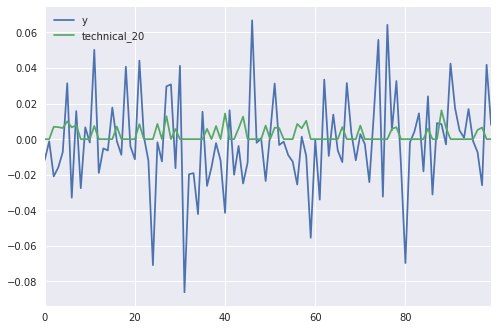

In [4]:
df_train[['y', 'technical_20']].iloc[:100,:].plot()

Time to select the best features to learn.

In [ ]:
# correlation coeficient
x_cols = [col for col in new_df_train.columns if col not in ['id', 'timestamp', 'y']]

coefs = []

for col in x_cols:
    coefs.append(np.corrcoef(new_df_train[col], new_df_train.y)[0,1])

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


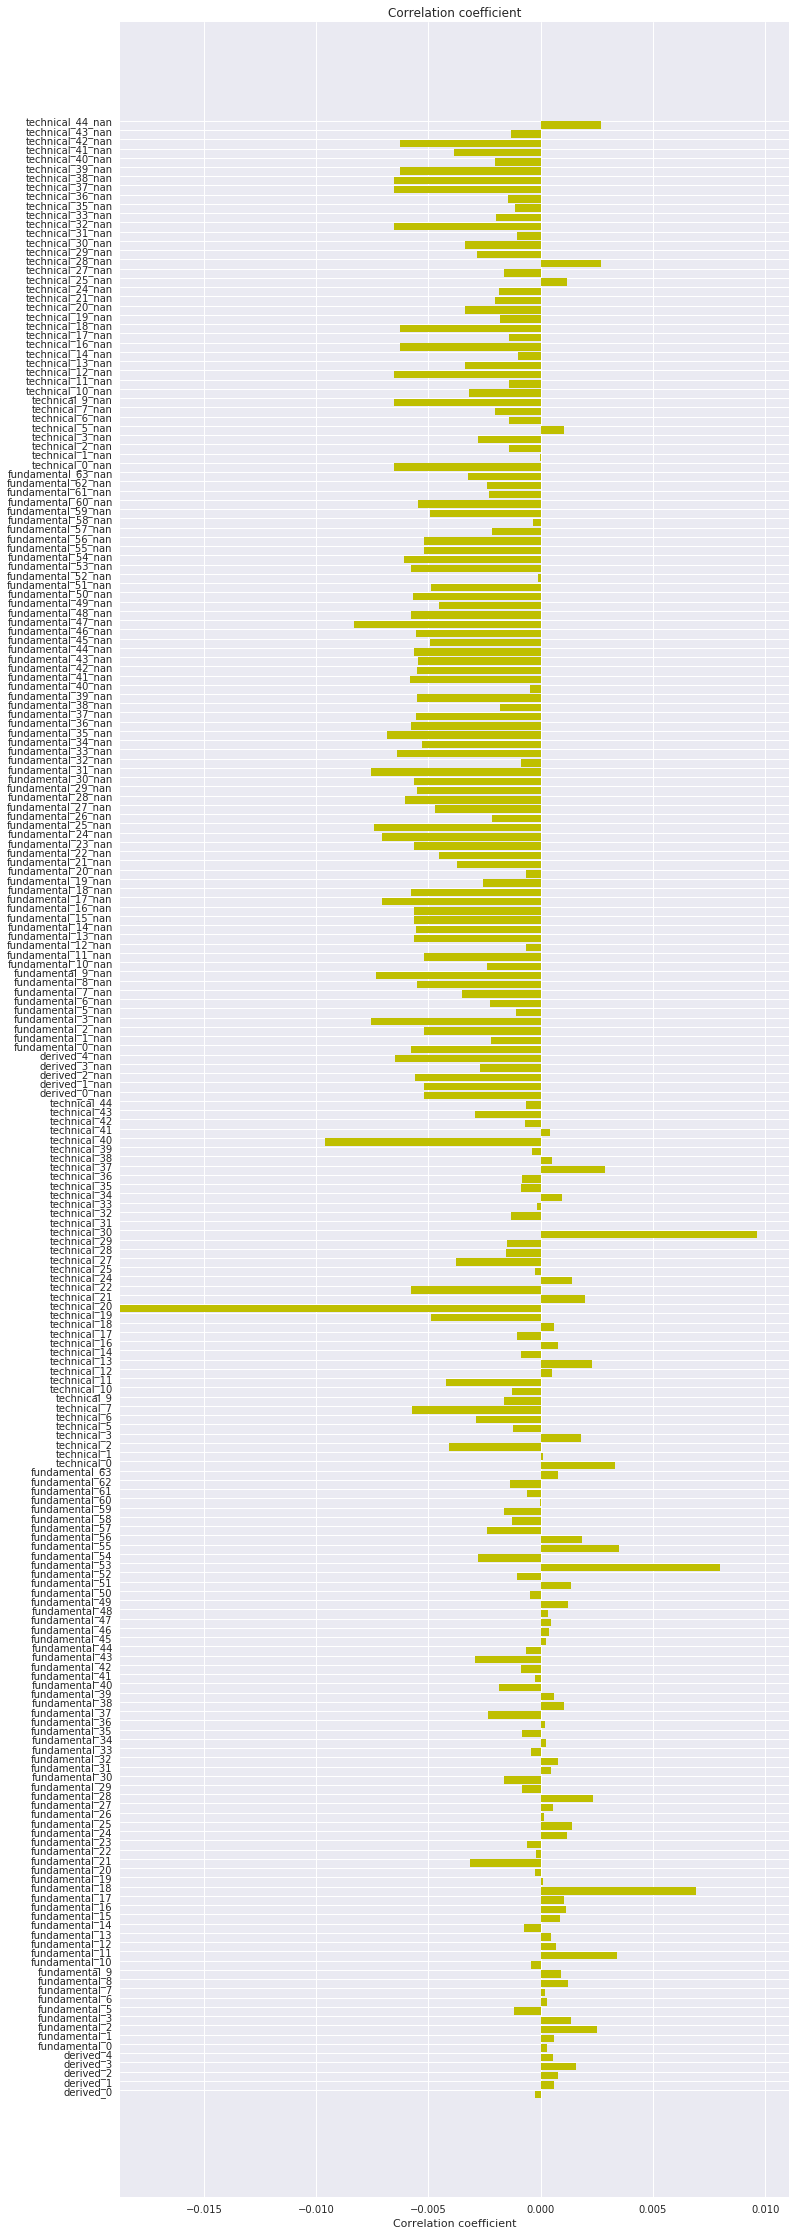

In [55]:
y_pos = np.arange(len(x_cols))
width = 0.9
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(y_pos, np.array(coefs), color='y')
ax.set_yticks(y_pos+((width)/2.))
ax.set_yticklabels(x_cols, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient")
plt.show()

In [53]:
# sorting coefs in ascending order and return its index
index = sorted(range(len(coefs)), key=lambda i: abs(coefs[i]))
print(index)

[94, 177, 64, 69, 23, 164, 96, 30, 40, 26, 11, 89, 0, 45, 38, 24, 49, 5, 10, 170, 52, 50, 102, 104, 37, 14, 35, 54, 51, 152, 17, 78, 101, 4, 31, 83, 6, 65, 27, 43, 1, 124, 132, 48, 107, 105, 16, 18, 81, 2, 67, 36, 33, 39, 99, 46, 19, 144, 80, 98, 13, 97, 188, 180, 82, 21, 42, 201, 56, 117, 20, 28, 204, 196, 9, 12, 53, 72, 76, 62, 212, 95, 8, 55, 66, 178, 181, 185, 190, 29, 88, 205, 92, 91, 3, 34, 63, 197, 75, 71, 150, 192, 44, 60, 195, 203, 86, 182, 194, 209, 138, 169, 114, 118, 79, 173, 41, 32, 61, 122, 174, 7, 131, 198, 111, 213, 179, 58, 199, 100, 73, 47, 106, 25, 184, 175, 68, 187, 193, 200, 15, 59, 119, 133, 90, 210, 70, 77, 134, 161, 139, 163, 84, 157, 171, 108, 115, 123, 167, 168, 109, 146, 172, 155, 154, 120, 151, 141, 126, 149, 158, 110, 125, 128, 135, 142, 127, 156, 162, 74, 113, 165, 148, 160, 130, 87, 153, 140, 166, 189, 211, 191, 208, 145, 112, 176, 183, 186, 202, 206, 207, 147, 22, 136, 129, 121, 137, 116, 143, 57, 159, 103, 93, 85]


In [54]:
# Let's selected the top 6 features
feature_cols = index[-6:]
for i in feature_cols:
    print((x_cols[i], coefs[i]))

('fundamental_31_nan', -0.007567235510688752)
('fundamental_53', 0.00801017747612311)
('fundamental_47_nan', -0.0082980366481522384)
('technical_40', -0.0095880282514506313)
('technical_30', 0.0096581342886955125)
('technical_20', -0.018752338839215128)


In [56]:
# Time to check feature colinearity
selected_cols = [x_cols[i] for i in feature_cols]

for feature in [x_cols[i] for i in feature_cols]:
    print(feature)
    print((min(new_df_train[feature]), max(new_df_train[feature])))

fundamental_31_nan
(False, True)
fundamental_53
(-629.18549, 61.721714)
fundamental_47_nan
(False, True)
technical_40
(-0.5250904, 1.5692652)
technical_30
(0.0, 0.064815201)
technical_20
(0.0, 0.067848153)


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


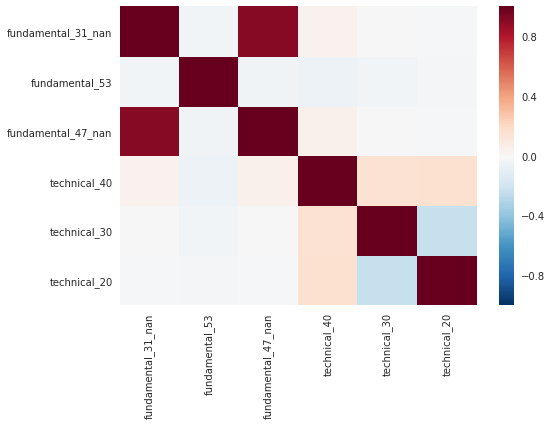

In [57]:
sns.heatmap(new_df_train[selected_cols].corr())

fundamental_31_nan is strongly correlated with fundamental_47_nan. Discard one of them.

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


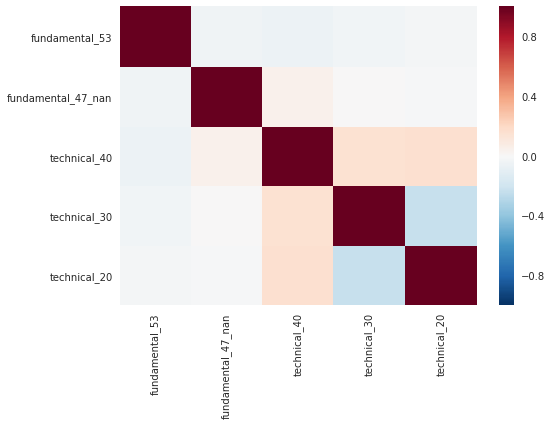

In [58]:
sns.heatmap(new_df_train[['fundamental_53','fundamental_47_nan','technical_40', 'technical_30', 'technical_20']].corr())

## Machine Learning ##

In [8]:
# metric used by Kaggle

def R_metric(y, y_pred):
    R2 = 1 - np.sum((y - y_pred)**2) / np.sum((y - np.mean(y))**2)
    R = np.sign(R2) * np.sqrt(abs(R2))
    return R

R_scorer = make_scorer(R_metric)

In [ ]:
Looking the learning curve to check for variance/bias

[learning_curve] Training set sizes: [ 151946  493826  835706 1177586 1519466]
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................ , score=-0.005696, total=   1.3s
[CV]  ................................................................
[CV] ................................. , score=0.023957, total=   3.2s
[CV]  ................................................................
[CV] ................................. , score=0.022142, total=   4.2s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Done   3 out of  50 | elapsed:    5.0s remaining:  1.3min


[CV] ................................. , score=0.008488, total=   1.3s
[CV]  ................................................................
[CV] ................................. , score=0.020180, total=   6.0s
[CV]  ................................................................
[CV] ................................. , score=0.005711, total=   2.7s
[CV]  ................................................................
[CV] ................................. , score=0.020405, total=   7.2s
[CV]  ................................................................
[CV] ................................. , score=0.016743, total=   3.8s
[CV]  ................................................................
[CV] ................................ , score=-0.006466, total=   1.3s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed:   11.0s remaining:   50.1s


[CV] ................................ , score=-0.027937, total=   2.6s
[CV]  ................................................................
[CV] ................................. , score=0.017364, total=   5.7s
[CV]  ................................................................
[CV] ................................ , score=-0.027692, total=   3.9s
[CV]  ................................................................
[CV] ................................. , score=0.013973, total=   6.7s
[CV]  ................................................................
[CV] ................................. , score=0.026326, total=   1.2s
[CV]  ................................................................
[CV] ................................. , score=0.028022, total=   2.7s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed:   18.5s remaining:   43.1s


[CV] ................................ , score=-0.027801, total=   5.7s
[CV]  ................................................................
[CV] ................................ , score=-0.022888, total=   6.6s
[CV]  ................................................................
[CV] ................................. , score=0.028819, total=   3.8s
[CV]  ................................................................
[CV] ................................ , score=-0.012687, total=   1.4s
[CV]  ................................................................
[CV] ................................. , score=0.006788, total=   2.6s
[CV]  ................................................................
[CV] ................................. , score=0.027131, total=   5.3s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:   24.4s remaining:   33.8s


[CV] ................................. , score=0.025025, total=   6.7s
[CV]  ................................................................
[CV] ................................. , score=0.013483, total=   4.0s
[CV]  ................................................................
[CV] ................................ , score=-0.017977, total=   1.3s
[CV]  ................................................................
[CV] ................................. , score=0.008316, total=   2.5s
[CV]  ................................................................
[CV] ................................. , score=0.015178, total=   5.3s
[CV]  ................................................................
[CV] ................................. , score=0.012340, total=   6.6s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed:   31.8s remaining:   27.1s


[CV] ................................. , score=0.015143, total=   4.1s
[CV]  ................................................................
[CV] ................................ , score=-0.029280, total=   1.5s
[CV]  ................................................................
[CV] ................................ , score=-0.022337, total=   2.6s
[CV]  ................................................................
[CV] ................................. , score=0.015713, total=   5.4s
[CV]  ................................................................
[CV] ................................. , score=0.011959, total=   6.6s
[CV]  ................................................................
[CV] ................................ , score=-0.018361, total=   3.7s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed:   37.6s remaining:   19.4s


[CV] ................................. , score=0.009627, total=   1.2s
[CV]  ................................................................
[CV] ................................. , score=0.011548, total=   2.5s
[CV]  ................................................................
[CV] ................................ , score=-0.013891, total=   5.3s
[CV]  ................................................................
[CV] ................................. , score=0.014266, total=   3.7s
[CV]  ................................................................
[CV] ................................ , score=-0.013431, total=   6.6s
[CV]  ................................................................
[CV] ................................ , score=-0.043181, total=   1.2s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed:   44.3s remaining:   12.5s


[CV] ................................ , score=-0.012661, total=   2.6s
[CV]  ................................................................
[CV] ................................. , score=0.015204, total=   5.1s
[CV]  ................................................................
[CV] ................................ , score=-0.015387, total=   3.9s
[CV]  ................................................................
[CV] ................................. , score=0.014216, total=   6.6s
[CV]  ................................................................
[CV] ................................ , score=-0.051292, total=   1.2s
[CV]  ................................................................
[CV] ................................. , score=0.022605, total=   2.5s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:   51.6s remaining:    5.7s


[CV] ................................ , score=-0.007443, total=   5.3s
[CV]  ................................................................
[CV] ................................. , score=0.007576, total=   6.5s
[CV] ................................. , score=0.023907, total=   3.8s
[CV] ................................. , score=0.028829, total=   3.8s
[CV] ................................. , score=0.026485, total=   4.4s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   56.8s finished


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py'>

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


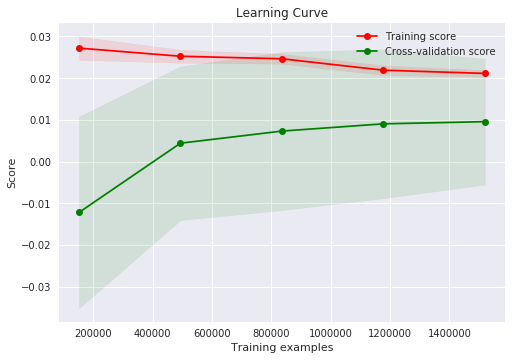

In [63]:
features = new_df_train[['fundamental_53','technical_40', 'fundamental_47_nan','technical_30', 'technical_20']]
target =  new_df_train.y

plot_learning_curve(Ridge(random_state=1, normalize = True), 'Learning Curve', 
                    features, target, cv=10, scoring=R_scorer, n_jobs=-1)

The curve seems surprising nice to start with. Ridge is good choice in this case.

In [7]:
# Mimicking the Kaggle train/test console

features = new_df_train[new_df_train.timestamp<906][['fundamental_53','fundamental_47_nan','technical_40', 'technical_30', 'technical_20']]
target = new_df_train[new_df_train.timestamp<906].y

rdg = Ridge(random_state=1, normalize = True)
model = rdg.fit(features, target)
y_pred = model.predict(new_df_train[new_df_train.timestamp>=906][['fundamental_53','fundamental_47_nan','technical_40', 'technical_30', 'technical_20']])

## Further Investigation ##

In [ ]:
# How bad is the performance?

test = new_df_train[new_df_train.timestamp>=906]
y = test.y

y_compare = np.row_stack((y_pred, y))

# Standard deviation of y_true and y_pred
y_std = np.std(y_compare, axis=0)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


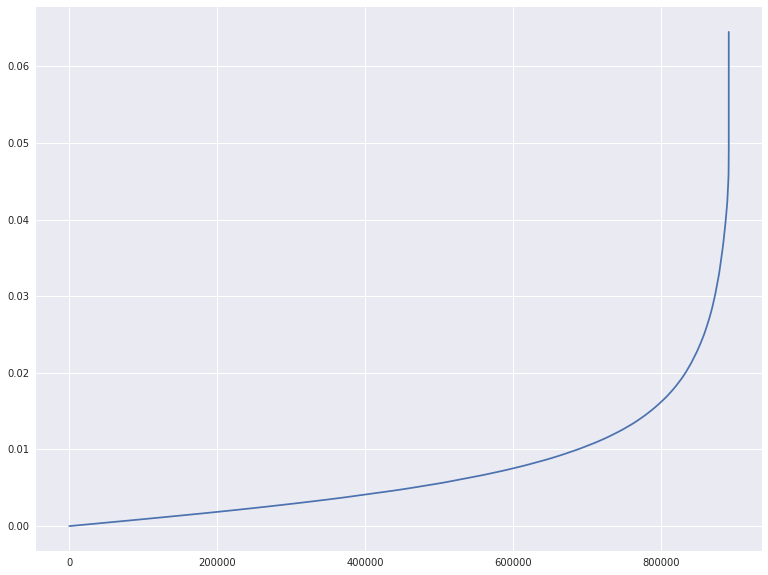

In [31]:
plt.figure(figsize=(13,10))
plt.plot(sorted(y_std))

It looks bad. About a third are having high standard deviation

In [28]:
# Again, ranking by index here
index = sorted(range(len(y_std)), key=lambda i: y_std[i])

# Find out the rows with the worst standard deviations
y_trouble = index[-10:]
test.iloc[y_trouble]

,id,timestamp,derived_0,derived_1,derived_2,derived_3,derived_4,fundamental_0,fundamental_1,fundamental_2,...,technical_35_nan,technical_36_nan,technical_37_nan,technical_38_nan,technical_39_nan,technical_40_nan,technical_41_nan,technical_42_nan,technical_43_nan,technical_44_nan
1560718,1583,1673,-1.389630,1.236950,0.020909,-0.928441,0.011996,0.038455,-0.237333,-0.029062,...,0,0,0,0,0,0,0,0,0,0
1543449,1583,1657,-1.389630,1.236950,0.020909,-0.928441,0.011996,0.038455,-0.237333,-0.029062,...,0,0,0,0,0,0,0,0,0,0
1537320,82,1652,-2.950205,0.352620,0.020909,-0.883966,0.011996,-0.442402,-0.236858,-0.029062,...,0,0,0,0,0,0,0,0,0,0
1504996,1539,1621,-3.669785,4.514560,0.020909,-0.870691,0.011996,-0.400616,-0.096888,-0.029062,...,0,0,0,0,0,0,0,0,0,0
1432462,1583,1551,-1.389014,1.236127,0.020909,-0.774125,0.011996,-0.009864,-0.237333,-0.029062,...,0,0,0,0,0,0,0,0,0,0
1502166,82,1619,-2.155774,0.475541,0.020909,-0.881352,0.011996,-0.390700,-0.236858,-0.029062,...,0,0,0,0,0,0,0,0,0,0
1525540,82,1641,-2.675037,0.429784,0.020909,-0.897755,0.011996,-0.438636,-0.236858,-0.029062,...,0,0,0,0,0,0,0,0,0,0
1541273,1539,1655,-3.896938,1.004463,0.020909,-0.857795,0.011996,-0.447692,-0.096888,-0.029062,...,0,0,0,0,0,0,0,0,0,0
1445741,1583,1564,-1.389572,1.236872,0.020909,-0.913822,0.011996,0.033877,-0.237333,-0.029062,...,0,0,0,0,0,0,0,0,0,0
1540554,82,1655,-3.004200,0.337761,0.020909,-0.880981,0.011996,-0.442402,-0.236858,-0.029062,...,0,0,0,0,0,0,0,0,0,0


In [29]:
y_std[y_trouble]

array([ 0.04871322,  0.04900475,  0.05074556,  0.05171403,  0.05212434,
        0.052984  ,  0.05328798,  0.05572273,  0.05632951,  0.06448812])

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


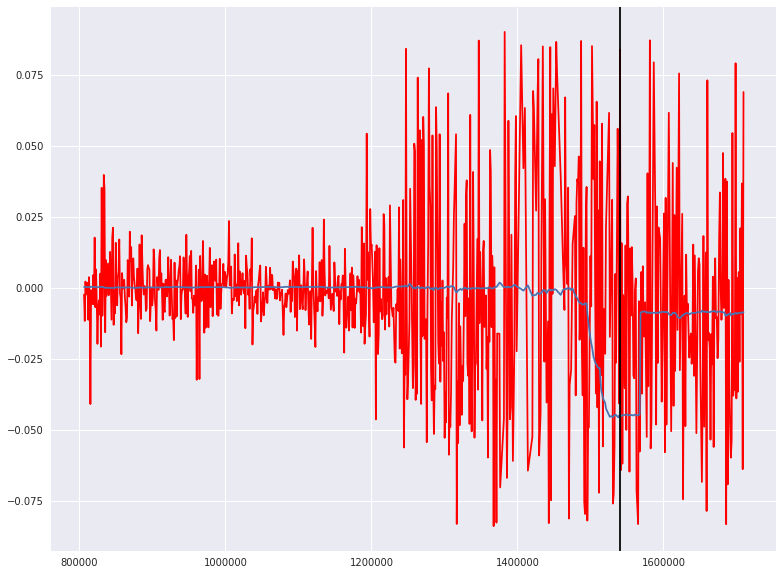

In [71]:
# Let's look at id=82, the worst of all

df_y_pred = pd.DataFrame(index = test.index)
df_y_pred['y'] = y_pred

plt.figure(figsize=(13,10))
index = test[test.id==82].index
plt.plot(test[test.id==82].y, color='r')
plt.plot(df_y_pred[test.id==82].y)
plt.axvline(1540554, color='k')

Ouch. Don't think the prediction caught the trend. Something is going on between timeframe 1500000 and 1600000. Further investigation required.